In [37]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
import random
import sklearn.metrics
from prettytable import PrettyTable 

### Q1

In [38]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [39]:
fname = '/content/gdrive/My Drive/Brown_tagged_train.txt'
file = open(fname,'r')
text = file.read()
file.close()

In [40]:
sents=[]
for line in text.split('\n'):
  #print(line)
  lst = []
  for wd in line.split():
    x = wd.split('/')

    if len(x)>2:
      y = []
      y.append('/'.join(x[:len(x)-1]))
      y.append(x[-1])
      x=y
      #print(x)
    lst.append(x)

  sents.append(lst)

In [41]:
sent_tag = sents
mod_sent_tag=[]
tot=0
mini = 1000
maxi = -1

for s in sent_tag:
  tot+=len(s)
  mini = min(len(s),mini)
  maxi = max(len(s),maxi)
  s.insert(0,('<start>','<start>'))
  s.append(('<end>','<end>'))
  mod_sent_tag.append(s)

print("The average length of sentences is "+str(round(tot/len(sent_tag),2)))
print("The minimum length of sentences is "+str(mini))
print("The maximum length of sentences is "+str(maxi))


The average length of sentences is 19.76
The minimum length of sentences is 0
The maximum length of sentences is 386


In [42]:
#mod_sent_tag

In [43]:
n1 = int(len(mod_sent_tag)*0.8)
train_data = mod_sent_tag[0:n1]
test_data = mod_sent_tag[n1:]

In [44]:
def get_train_word_tags(train_data):
  
  train_word_tag = {}
  for s in train_data:
    try:
      for w,t in s:
        w = w.lower()
        if t in train_word_tag:
          if w in train_word_tag[t]:
            train_word_tag[t][w]+=1
          else:
            train_word_tag[t][w]=1
        else:
          train_word_tag[t]={w:1}
    except:
      continue
  
  return train_word_tag

In [45]:
train_word_tag = get_train_word_tags(train_data)

In [ ]:
train_word_tag

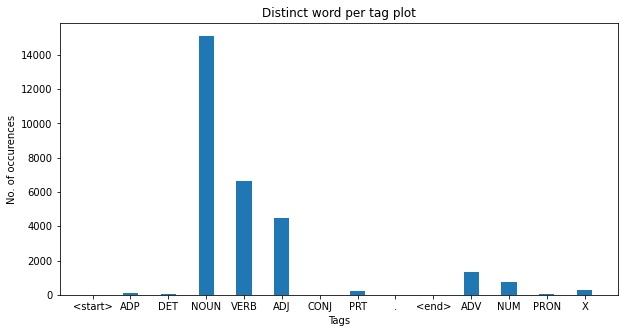

There are total 29017 words in the vocab
There are total 14 words in the vocab


In [47]:
tgs = []
cts = []
sumi = 0
for k in train_word_tag.keys():
  tgs.append(k)
  cts.append(len(train_word_tag[k]))
  sumi+=len(train_word_tag[k])
  #print(len(train_word_tag[k]))
fig = plt.figure(figsize = (10, 5))

plt.bar(tgs, cts,
		width = 0.4)

plt.xlabel("Tags")
plt.ylabel("No. of occurences")
plt.title("Distinct word per tag plot")
plt.show()
print("There are total "+str(sumi)+" words in the vocab")
print("There are total "+str(len(train_word_tag))+" words in the vocab")

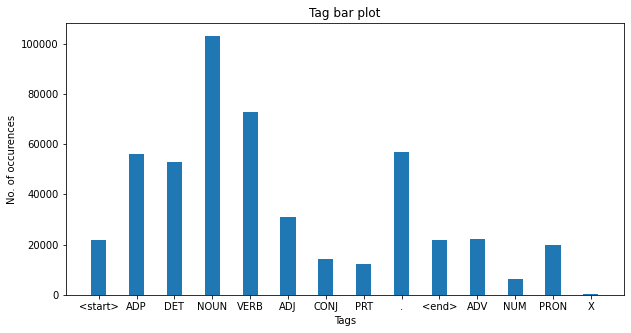

In [48]:
tgs = []
cts = []

for k in train_word_tag.keys():
  tgs.append(k)
  sumi=0
  for v in train_word_tag[k].keys():
    sumi += train_word_tag[k][v]
  cts.append(sumi)

fig = plt.figure(figsize = (10, 5))

plt.bar(tgs, cts,
		width = 0.4)

plt.xlabel("Tags")
plt.ylabel("No. of occurences")
plt.title("Tag bar plot")
plt.show()

In [49]:
#train_word_tag

In [50]:
def get_transmission_probs(train_word_tag):
  tem_prob={}
  for k in train_word_tag.keys():
    tem_prob[k]={}
    count = sum(train_word_tag[k].values())
    for k2 in train_word_tag[k].keys():
      tem_prob[k][k2]=train_word_tag[k][k2]/count
  return tem_prob

In [51]:
tem_prob = get_transmission_probs(train_word_tag)

In [52]:
#print(tem_prob)

In [53]:
def calculateBigrams(tokens):
  n = 2
  #tokens = 1*['<START>']+tokens
  l = [(tokens[i-1], tokens[i]) for i in range(1, len(tokens))]
  return l

In [54]:
#calculateBigrams([('<start>', '<start>'), ['At', 'ADP'], ['that', 'DET'], ['time', 'NOUN'], ['highway', 'NOUN'], ['engineers', 'NOUN'], ['traveled', 'VERB'], ['rough', 'ADJ'], ['and', 'CONJ'], ['dirty', 'ADJ'], ['roads', 'NOUN'], ['to', 'PRT'], ['accomplish', 'VERB'], ['their', 'DET'], ['duties', 'NOUN'], ['.', '.'], (''<end>'', ''<end>'')])

In [55]:
def get_bigram_tag_data(train_data):
  bigram_tag_data = {}
  for s in train_data:
    bi=list(calculateBigrams(s))
    # print(bi)
    # print(s)
    #break
    for b1,b2 in bi:
      if b1[1] in bigram_tag_data:
        if b2[1] in bigram_tag_data[b1[1]]:
          bigram_tag_data[b1[1]][b2[1]]+=1
        else:
          bigram_tag_data[b1[1]][b2[1]]=1
      else:
        bigram_tag_data[b1[1]]={b2[1]:1}
    
    btag_prob={}
    for k in bigram_tag_data.keys():
      btag_prob[k]={}
      count=sum(bigram_tag_data[k].values())
      for k2 in bigram_tag_data[k].keys():
        btag_prob[k][k2]=bigram_tag_data[k][k2]/count
  
  return btag_prob

In [56]:
btag_prob = get_bigram_tag_data(train_data)

In [66]:
def train(train_data, btag_prob, test_data):
  tags_of_tokens = {}
  count=0
  for s in train_data:
    try:
      for (w,t) in s:
        w=w.lower()
        try:
          if t not in tags_of_tokens[w]:
            tags_of_tokens[w].append(t)
        except:
          l = []
          l.append(t)
          tags_of_tokens[w] = l
    except:
      continue

  test_words=[]
  test_tags=[]
  for s in test_data:
    temp_word=[]
    temp_tag=[]
    try:
      for (w,t) in s:
        temp_word.append(w.lower())
        temp_tag.append(t)
      test_words.append(temp_word)
      test_tags.append(temp_tag)
    except:
      continue
      #print(s)

  ptags = []                
  for x in range(len(test_words)):   
    s = test_words[x]

    store = {}              
    for q in range(len(s)):
      step = s[q]

      if q == 1:                
        store[q] = {}
        try:
          tags = tags_of_tokens[step]
        except:
          tags = ['NOUN']
        for t in tags:
          try:
            store[q][t] = ['<start>',btag_prob['<start>'][t]*tem_prob[t][step]]
          except:
            store[q][t] = ['<start>',0.0001]
      
      if q>1:
        store[q] = {}
        previous_states = list(store[q-1].keys())   
        try:
          current_states  = tags_of_tokens[step]              
        except:
          current_states = ['NOUN']

        for t in current_states:                             
          temp = []
          for pt in previous_states:                         
            try:
              temp.append(store[q-1][pt][1]*btag_prob[pt][t]*tem_prob[t][step])
            except:
              temp.append(store[q-1][pt][1]*0.0001)

          max_temp_index = temp.index(max(temp))
          best_pt = previous_states[max_temp_index]
          store[q][t]=[best_pt,max(temp)]

    pred_tags = []
    total_steps_num = store.keys()
    last_step_num = max(total_steps_num)
    #print(total_steps_num)
    for bs in range(len(total_steps_num)):
      step_num = last_step_num - bs
      
      if step_num == last_step_num:
        pred_tags.append('<end>')
        pred_tags.append(store[step_num]['<end>'][0])
      
      if step_num<last_step_num and step_num>0:
        pred_tags.append(store[step_num][pred_tags[len(pred_tags)-1]][0])
    
    ptags.append(list(reversed(pred_tags)))

  return ptags,test_tags


In [58]:
ptags,test_tags = train(train_data, btag_prob, test_data)

In [59]:
def accu(pred_tags, test_tags):
  cor = 0 
  incor = 0
  d={}
  for i in range(len(test_tags)):
    gt = test_tags[i]
    pred = pred_tags[i]
    for h in range(len(gt)):
      try:
        if gt[h] == pred[h]:
          cor = cor+1
        else:
          try:
            d[gt[h]]+=1
          except:
            d[gt[h]]=1
          incor = incor +1 
      except:
        print(len(gt))
        print(len(pred))
  print(d)  

  print('Accuracy:',cor/(cor+incor))

In [60]:
accu(ptags, test_tags)

{'ADJ': 994, 'VERB': 1028, 'ADV': 577, 'NOUN': 685, 'DET': 302, 'NUM': 15, 'ADP': 522, 'PRON': 174, 'PRT': 464, 'X': 122, 'CONJ': 5, '.': 1}
Accuracy: 0.953893452285523


['ADJ', 'VERB', 'ADV', 'NOUN', 'DET', 'NUM', 'ADP', 'PRON', 'PRT', 'X', 'CONJ', '.']
[994, 1028, 577, 685, 302, 15, 522, 174, 464, 122, 5, 1]


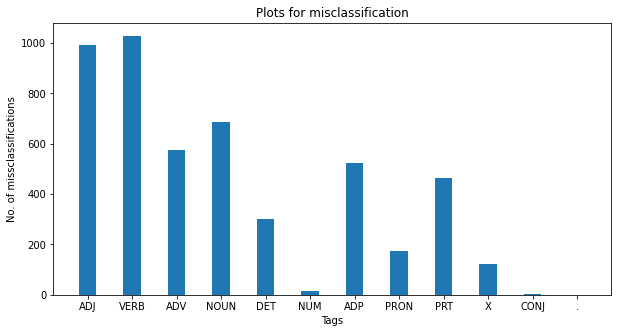

In [74]:
dict = {'ADJ': 994, 'VERB': 1028, 'ADV': 577, 'NOUN': 685, 'DET': 302, 'NUM': 15, 'ADP': 522, 'PRON': 174, 'PRT': 464, 'X': 122, 'CONJ': 5, '.': 1}
x = list(dict.keys())
y = list(dict.values())
print(x)
print(y)

fig = plt.figure(figsize = (10, 5))

plt.bar(x, y,
		width = 0.4)

plt.xlabel("Tags")
plt.ylabel("No. of missclassifications")
plt.title("Plots for misclassification")
plt.show()

In [61]:
random.shuffle(mod_sent_tag)

In [62]:
def cf_matrix(pred_tags,test_tags):
  head = ['<start>','PRON','VERB','ADP','DET','ADJ','NOUN','.','ADV','CONJ','X','PRT','NUM','<end>']
  myTable = PrettyTable(head)
  i=0
  d={}
  for wd in head:
    d[wd]=i
    i+=1
  mx=[]
  for i in range(14):
    mx.append([0]*14)
  print(d)

  for i in range(len(test_tags)):
    gt = test_tags[i]
    pred = pred_tags[i]
    for h in range(len(gt)):
      mx[ d[gt[h]] ][ d[pred[h]] ]+=1
  for row in mx:
    myTable.add_row(row)
  print(myTable)
  return d,mx



In [63]:
def recall(d,mx):
  for tag,dex in d.items():
    print("Recall of tag "+tag+" is:")
    ans = round(mx[dex][dex]/sum(mx[:][dex]),2)
    print(ans)

def precision(d,mx):
  for tag,dex in d.items():
    print("Precision of tag "+tag+" is:")
    ans = round(mx[dex][dex]/sum(mx[dex][:]),2)
    print(ans)

def f1score(d,mx):
  for tag,dex in d.items():
    print("F1 score of tag "+tag+" is:")
    p = round(mx[dex][dex]/sum(mx[dex][:]),2)
    r = round(mx[dex][dex]/sum(mx[:][dex]),2)
    print(2*p*r/(p+r))

In [64]:
def ttpt(test_tags, ptags):
  tt=[]
  for lst in test_tags:
    tt+=lst

  pt=[]
  for lst in ptags:
    pt+=lst
  return tt,pt

In [67]:
n1 = int(len(mod_sent_tag)*0.3)
n2 = int(len(mod_sent_tag)*0.6)

#fold1
train_data = mod_sent_tag[0:n2]
test_data = mod_sent_tag[n2:]

train_word_tag = get_train_word_tags(train_data)
tem_prob = get_transmission_probs(train_word_tag)
btag_prob = get_bigram_tag_data(train_data)
ptags, test_tags = train(train_data, btag_prob, test_data)
tt,pt = ttpt(test_tags,ptags)
print(sklearn.metrics.precision_recall_fscore_support(tt,pt,average='weighted'))
d, mx = cf_matrix(ptags, test_tags)
precision(d,mx)
recall(d,mx)
f1score(d,mx)

(0.9592192557999171, 0.9586537694204219, 0.9584009938177712, None)
{'<start>': 0, 'PRON': 1, 'VERB': 2, 'ADP': 3, 'DET': 4, 'ADJ': 5, 'NOUN': 6, '.': 7, 'ADV': 8, 'CONJ': 9, 'X': 10, 'PRT': 11, 'NUM': 12, '<end>': 13}
+---------+-------+-------+-------+-------+-------+-------+-------+------+------+----+------+------+-------+
| <start> |  PRON |  VERB |  ADP  |  DET  |  ADJ  |  NOUN |   .   | ADV  | CONJ | X  | PRT  | NUM  | <end> |
+---------+-------+-------+-------+-------+-------+-------+-------+------+------+----+------+------+-------+
|  10997  |   0   |   0   |   0   |   0   |   0   |   0   |   0   |  0   |  0   | 0  |  0   |  0   |   0   |
|    0    | 10601 |   0   |  248  |   94  |   0   |   17  |   0   |  0   |  0   | 0  |  0   |  0   |   0   |
|    0    |   0   | 33204 |   38  |   0   |   79  |  2281 |   0   |  27  |  0   | 5  |  12  |  0   |   0   |
|    0    |   35  |   20  | 25124 |  149  |   21  |   22  |   16  | 396  |  22  | 0  | 322  |  0   |   0   |
|    0    |  242  |

In [ ]:
#fold2
train_data = mod_sent_tag[n1:]
test_data = mod_sent_tag[0:n1]

train_word_tag = get_train_word_tags(train_data)
tem_prob = get_transmission_probs(train_word_tag)
btag_prob = get_bigram_tag_data(train_data)
ptags, test_tags = train(train_data, btag_prob, test_data)
tt,pt = ttpt(test_tags,ptags)
print(sklearn.metrics.precision_recall_fscore_support(tt,pt,average='weighted'))
d, mx = cf_matrix(ptags, test_tags)
precision(d,mx)
recall(d,mx)
f1score(d,mx)

In [ ]:
#fold3
train_data = mod_sent_tag[0:n1]+mod_sent_tag[n2:]
test_data = mod_sent_tag[n1:n2]

train_word_tag = get_train_word_tags(train_data)
tem_prob = get_transmission_probs(train_word_tag)
btag_prob = get_bigram_tag_data(train_data)
ptags, test_tags = train(train_data, btag_prob, test_data)
tt,pt = ttpt(test_tags,ptags)
print(sklearn.metrics.precision_recall_fscore_support(tt,pt,average='weighted'))
d, mx = cf_matrix(ptags, test_tags)
precision(d,mx)
recall(d,mx)
f1score(d,mx)

In [70]:
for k in train_word_tag.keys():
  print(k)

<start>
DET
NOUN
ADJ
ADP
PRT
VERB
.
PRON
ADV
<end>
NUM
CONJ
X


{'NOUN': 808, 'VERB': 1769, 'ADJ': 1589, 'PRON': 239, 'NUM': 200, 'PRT': 517, 'ADV': 908, 'ADP': 696, 'DET': 310, 'X': 148, 'CONJ': 21, '.': 1}
Accuracy: 0.9599036262568371
